In [11]:
import numpy as np
import h5py
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from datetime import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# Choose which device to run the code on.  I am currently using GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [3]:
#load MNIST data
MNIST_data = h5py.File('MNISTdata.hdf5', 'r')
x_train = np.float32(MNIST_data['x_train'][:])
y_train = np.int32(np.array(MNIST_data['y_train'][:,0]))
x_test = np.float32(MNIST_data['x_test'][:])
y_test = np.int32(np.array( MNIST_data['y_test'][:,0]))

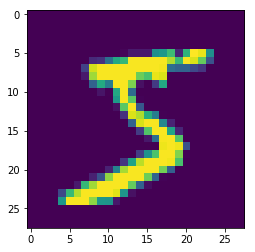

The label is 5


In [13]:
fig, ax = plt.subplots()
ax.imshow(x_train[0, ...].reshape((28, 28)))
plt.show()

print("The label is {}".format(y_train[0]))

In [4]:
class ImageDataset(Dataset):
    """Image dataset"""
    
    # Create a constructor for this class
    def __init__(self, 
                images=x_train,
                labels=y_train):
        self.images = images
        self.labels = labels.reshape(-1, 1)
        
    # Define the len operator
    def __len__(self):
        return len(self.labels)
    
    # Define the indexing operator
    def __getitem__(self, idx):
        image = torch.Tensor(self.images[idx, :])
        label = torch.LongTensor(self.labels[idx, :])
        
        return {'image': image, 'label': label}

In [5]:
class Network(nn.Module):
    def __init__(self):
        # Inheritance!
        super(Network, self).__init__()
        # Create a neural network with shape 784 --> 1024 --> 10
        self.pre = nn.Sequential(
                                nn.Linear(784, 1024),
                                nn.Sigmoid(),
                                nn.Linear(1024, 10))
        
    # Define the forward function of the network
    def forward(self, input):
        out = self.pre(input)
        return out

In [9]:
# Given the logits of the network compute the accuracy of the classifier
def accuracy(logits, labels):
    # Detach the tensor from the graph, send to cpu, and then send to numpy
    logits = logits.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy().astype(np.float32)
    # Notice the simple use of argmax to find the best class
    logits = np.argmax(logits, axis=1)
    # Now calculate the accuracy
    return np.sum(logits == labels)/len(labels)

In [10]:
# Get the model
model = Network()

# Get dataset and dataloader
dataset = ImageDataset()
dataloader = DataLoader(dataset, 
                    batch_size=100, 
                    shuffle=True)

# Before the training starts setup the checkpoint folder
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
checkpoint_directory = os.path.join('.', dt_string)
if not os.path.exists(checkpoint_directory):
    os.mkdir(checkpoint_directory)

# Get the optimizer
optimizer = torch.optim.Adam(list(model.parameters()), 
                            lr=0.01, 
                            betas=(0.5, 0.999))

# Use cross entropy loss function
criterion = nn.CrossEntropyLoss()

# Operate in training mode
model.train()
model.to(device)

for epoch in range(0, 100):

    epoch_iter = 0

    for i, sample in enumerate(dataloader):

        inputs = sample['image'].to(device)
        label = sample['label']
        label = label.reshape(label.shape[0],).to(device)
        optimizer.zero_grad()

        # Run the network on the features to get the logits
        output = model(inputs)

        # Perform optimization
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            print('The loss in epoch {}, iteration {} is {}'.format(epoch, i, loss))
            print('The accuracy is {}'.format(accuracy(output, label)))
    # Save a checkpoint every 10 epochs
    if epoch % 10 == 0:       
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    }, os.path.join(checkpoint_directory, 'checkpoint_{:05d}.pth'.format(epoch)))

The loss in epoch 0, iteration 0 is 2.3263962268829346
The accuracy is 0.13
The loss in epoch 1, iteration 0 is 0.08894797414541245
The accuracy is 0.97
The loss in epoch 2, iteration 0 is 0.08602725714445114
The accuracy is 0.97
The loss in epoch 3, iteration 0 is 0.02667687088251114
The accuracy is 0.99
The loss in epoch 4, iteration 0 is 0.03294758498668671
The accuracy is 0.99
The loss in epoch 5, iteration 0 is 0.033754244446754456
The accuracy is 0.98
The loss in epoch 6, iteration 0 is 0.024294301867485046
The accuracy is 0.99


KeyboardInterrupt: 